## Load from CVS
The code in this notebook copies the cvs files for beaked whales from S3 to HDFS and then loads the data into 
a spark DataFrame.


In [ ]:
#sc.stop()

In [2]:
from pyspark import SparkContext
sc = SparkContext(master=master_url, pyFiles=['lib/numpy_pack.py','lib/row_parser.py','lib/spark_PCA.py'])

from pyspark.sql import Row, SQLContext,DataFrame
from pyspark.sql.types import *

sqlContext = SQLContext(sc)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [175]:
#!pip install --upgrade pip

#!sudo yum install -y gcc gcc-c++
!sudo pip install --upgrade pandas
import pandas as pd

You are using pip version 6.1.1, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Requirement already up-to-date: pandas in /usr/local/lib64/python2.7/site-packages
Requirement already up-to-date: python-dateutil in /usr/local/lib/python2.7/site-packages (from pandas)
Requirement already up-to-date: pytz>=2011k in /usr/local/lib/python2.7/site-packages (from pandas)
Requirement already up-to-date: numpy>=1.7.0 in /usr/local/lib64/python2.7/site-packages (from pandas)
Requirement already up-to-date: six>=1.5 in /usr/local/lib/python2.7/site-packages (from python-dateutil->pandas)


ImportError: C extension: hashtable not built. If you want to import pandas from the source directory, you may need to run 'python setup.py build_ext --inplace --force' to build the C extensions first.

In [174]:
#!sudo /usr/local/bin/pip install scipy
!sudo /usr/local/bin/pip install --upgrade numpy

%load_ext autoreload
%autoreload # use this magic to reload modules

import pandas as pd
import datetime as dt

#import scipy
#from scipy.io import loadmat,savemat,whosmat

from string import split
from collections import Counter
import re
import numpy as np
from numpy import shape

from glob import glob

print 'numpy version=',np.__version__, 'should be > 1.10'
#print 'scipy version=',scipy.__version__
#print 'pandas version=',pd.__version__

sudo: /usr/local/bin/pip: command not found
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ImportError: C extension: hashtable not built. If you want to import pandas from the source directory, you may need to run 'python setup.py build_ext --inplace --force' to build the C extensions first.

### Format of cvs files
|field name     | Description               | Data Type
|---------------|---------------------------|--------------
|0: time        | time of click             | string in datetime format `%Y-%m-%d %H:%M:%S.%f`
|1: species		| Initial species classification	        | 'str'
|2: site		| name of site		        | 'str'
|3: rec_no		| recording number		    | 'str'
|4: bout_i		| bout number		        | numpy.int64
|5: peak2peak	| peak to peak magnitude    | 			numpy.float64
|6: MSN	        |	wave form |		 an array of length 202
|208: MSP		|	spectra |	 an array of length 101  
|309: TPWS1		| 1 if click appears in TPWS1	| 	bool
|310: MD1		|	--- " ---	in MD1|	bool
|311: FD1	    |	--- " ---	in FD1|	bool
|312: TPWS2		| 1 if click appears in TPWS2	| 	bool
|313: MD2		|	--- " ---	in MD2|	bool
|314: FD2	    |	--- " ---	in FD2|	bool
|315: TPWS3		| 1 if click appears in TPWS3	| 	bool
|316: MD3		|	--- " ---	in MD3|	bool
|317: FD3	    |	--- " ---	in FD3|	bool
total number of fields= 318


In [4]:
%autoreload # use this magic to reload modules

### check  S3 contents

In [5]:
#%cd /root/ipython/BeakedWhaleClassification/

In [6]:
#remember to set credentials under "setup S3" in the cluster setup page
s3helper.open_bucket('while-classification')
s3helper.ls_s3()

[u'CVS',
 u'DT_Cuviers',
 u'DT_Gervais',
 u'GC_Cuviers',
 u'GC_Gervais',
 u'MC_Cuviers',
 u'MC_Gervais']

In [7]:
dirs=s3helper.ls_s3('CVS')
dirs[:10]

[u'CVS/DT.01.Cuviers',
 u'CVS/DT.01.Gervais',
 u'CVS/DT.02.Cuviers',
 u'CVS/DT.02.Gervais',
 u'CVS/DT.03.Cuviers',
 u'CVS/DT.03.Gervais',
 u'CVS/DT.04.Cuviers',
 u'CVS/DT.04.Gervais',
 u'CVS/DT.05.Cuviers',
 u'CVS/DT.05.Gervais']

In [8]:
from time import time

### Copy from S3 to HDFS

In [10]:
s3helper.ls_hdfs('CVS')

Found 556 items
-rw-r--r--   3 ec2-user supergroup   26169314 2017-01-17 20:28 /CVS/DT.01.Cuviers.1.cvs
-rw-r--r--   3 ec2-user supergroup   28240917 2017-01-17 20:28 /CVS/DT.01.Cuviers.10.cvs
-rw-r--r--   3 ec2-user supergroup   30325964 2017-01-17 20:28 /CVS/DT.01.Cuviers.11.cvs
-rw-r--r--   3 ec2-user supergroup   28216304 2017-01-17 20:28 /CVS/DT.01.Cuviers.12.cvs
-rw-r--r--   3 ec2-user supergroup   27627479 2017-01-17 20:28 /CVS/DT.01.Cuviers.13.cvs
-rw-r--r--   3 ec2-user supergroup   29293718 2017-01-17 20:28 /CVS/DT.01.Cuviers.14.cvs
-rw-r--r--   3 ec2-user supergroup   35160719 2017-01-17 20:28 /CVS/DT.01.Cuviers.15.cvs
-rw-r--r--   3 ec2-user supergroup   26283569 2017-01-17 20:28 /CVS/DT.01.Cuviers.16.cvs
-rw-r--r--   3 ec2-user supergroup   27017861 2017-01-17 20:28 /CVS/DT.01.Cuviers.17.cvs
-rw-r--r--   3 ec2-user supergroup   25641677 2017-01-17 20:28 /CVS/DT.01.Cuviers.18.cvs
-rw-r--r--   3 ec2-user supergroup   28301586 2017-01-17 20:28 /CVS/DT.01.Cuviers.19.cvs
-rw-r-

In [ ]:
t1=time()
s3helper.s3_to_hdfs('CVS', 'CVS')
time()-t1


In [11]:
# %load lib/row_parser.py
from pyspark.sql import Row, SQLContext,DataFrame
from pyspark.sql.types import *
import datetime as dt

def packArray(a):
    if type(a)!=np.ndarray:
        raise Exception("input to packArray should be numpy.ndarray. It is instead "+str(type(a)))
    return bytearray(a.tobytes())
def unpackArray(x,data_type=np.int16):
    return np.frombuffer(x,dtype=data_type)

def init_parser_parameters():
    def parse_date(s):
        return dt.datetime.strptime(s,'%Y-%m-%d %H:%M:%S.%f')
    def parse_array(a):
        np_array=np.array([np.float64(x) for x in a])
        return packArray(np_array)
    def parse_int(s):
        return int(s)
    def parse_float(s):
        return float(s)
    def parse_string(s):
        return(s)

    Fields=[('time', 'datetime'),
        ('species', 'str'),
        ('site', 'str'),
        ('rec_no', 'str'),
        ('bout_i', 'int'),
        ('peak2peak', 'float'),
        ('MSN', 'array',202),
        ('MSP', 'array',101),
        ('TPWS1', 'bool'),
        ('MD1', 'bool'),
        ('FD1', 'bool'),
        ('TPWS2', 'bool'),
        ('MD2', 'bool'),
        ('FD2', 'bool'),
        ('TPWS3', 'bool'),
        ('MD3', 'bool'),
        ('FD3', 'bool')]

    #global Parse_rules, RowObject
    #prepare date structure for parsing
    Parse_rules=[]
    index=0
    for field in Fields:
        _type=field[1]
        #print _type
        _len=1 # default length in terms of csv fields
        if _type =='array': 
            parser=parse_array
            _len=int(field[2])
        elif _type=='datetime': 
            parser=parse_date
        elif _type=='int': 
            parser=parse_int
        elif _type=='float': 
            parser=parse_float
        elif _type=='bool': 
            parser=parse_int
        elif _type=='str': 
            parser=parse_string
        else:
            print 'unrecognized type',_type
        rule={'name':field[0],
              'start':index,
              'end':index+_len,
              'parser':parser}
        print field,rule
        Parse_rules.append(rule)
        index+=_len

    field_names=[a['name'] for a in Parse_rules]
    RowObject= Row(*field_names)
    return Parse_rules,field_names,RowObject


### Read data into dataframe

In [12]:
import sys
sys.path.append('lib')
from row_parser import *

Parse_rules,field_names,RowObject = init_parser_parameters()


('time', 'datetime') {'start': 0, 'parser': <function parse_date at 0x7f1ebade5848>, 'end': 1, 'name': 'time'}
('species', 'str') {'start': 1, 'parser': <function parse_string at 0x7f1ebade50c8>, 'end': 2, 'name': 'species'}
('site', 'str') {'start': 2, 'parser': <function parse_string at 0x7f1ebade50c8>, 'end': 3, 'name': 'site'}
('rec_no', 'str') {'start': 3, 'parser': <function parse_string at 0x7f1ebade50c8>, 'end': 4, 'name': 'rec_no'}
('bout_i', 'int') {'start': 4, 'parser': <function parse_int at 0x7f1ebade58c0>, 'end': 5, 'name': 'bout_i'}
('peak2peak', 'float') {'start': 5, 'parser': <function parse_float at 0x7f1ebade51b8>, 'end': 6, 'name': 'peak2peak'}
('MSN', 'array', 202) {'start': 6, 'parser': <function parse_array at 0x7f1ebade5758>, 'end': 208, 'name': 'MSN'}
('MSP', 'array', 101) {'start': 208, 'parser': <function parse_array at 0x7f1ebade5758>, 'end': 309, 'name': 'MSP'}
('TPWS1', 'bool') {'start': 309, 'parser': <function parse_int at 0x7f1ebade58c0>, 'end': 310, 'n

In [13]:
def parse(row):
    #Parse_rules,field_names,RowObject = parser_data.value
    items=row.split(',')
    D=[]
    for pr in Parse_rules:
        start=pr['start']
        end=pr['end']
        parser=pr['parser']
        if end-start==1:
            D.append(parser(items[start]))
        else:
            D.append(parser(items[start:end]))
    return RowObject(*D)

In [14]:
from pyspark.sql import DataFrame
t1=time()
CVS_Data=sc.textFile("/CVS/")
CVS_Data.cache().count()
print time()-t1

15.1562740803


In [88]:
row=CVS_Data.first()

print 'a row:\n',row

parse(row)

a row:
2010-08-09 07:01:15.000002,Cuviers,DT,01,0,45.9858,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,123.1518,75.2794,-33.2284,-23.9326,-76.0488,-52.1295,-66.5504,-37.8580,-30.1298,2.2544,20.0773,19.0220,39.8708,36.0729,39.3590,28.7682,39.1766,18.8269,16.5995,-2.7279,-4.6016,-17.2059,-16.9708,-16.5006,-13.6036,-21.0872,-22.0780,-22.25

Row(time=datetime.datetime(2010, 8, 9, 7, 1, 15, 2), species=u'Cuviers', site=u'DT', rec_no=u'01', bout_i=0, peak2peak=45.9858, MSN=bytearray(b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00

In [17]:
RDD=CVS_Data.map(parse)

In [18]:
RDD.take(1)

[Row(time=datetime.datetime(2010, 8, 9, 7, 1, 15, 2), species=u'Cuviers', site=u'DT', rec_no=u'01', bout_i=0, peak2peak=45.9858, MSN=bytearray(b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0

In [19]:
df=sqlContext.createDataFrame(RDD)
df.show()

+--------------------+-------+----+------+------+---------+--------------------+--------------------+-----+---+---+-----+---+---+-----+---+---+
|                time|species|site|rec_no|bout_i|peak2peak|                 MSN|                 MSP|TPWS1|MD1|FD1|TPWS2|MD2|FD2|TPWS3|MD3|FD3|
+--------------------+-------+----+------+------+---------+--------------------+--------------------+-----+---+---+-----+---+---+-----+---+---+
|2010-08-09 07:01:...|Cuviers|  DT|    01|     0|  45.9858|[00 00 00 00 00 0...|[22 6C 78 7A A5 1...|    1|  0|  1|    0|  0|  0|    0|  0|  0|
|2010-08-09 07:02:...|Cuviers|  DT|    01|     0|  44.8432|[00 00 00 00 00 0...|[E3 36 1A C0 5B A...|    1|  0|  1|    0|  0|  0|    0|  0|  0|
|2010-08-09 07:03:...|Cuviers|  DT|    01|     0|  45.8631|[00 00 00 00 00 0...|[AC 8B DB 68 00 D...|    1|  0|  1|    0|  0|  0|    0|  0|  0|
|2010-08-09 07:05:...|Cuviers|  DT|    01|     0|  54.2039|[24 28 7E 8C B9 2...|[66 F7 E4 61 A1 6...|    1|  0|  1|    0|  0|  0|    0| 

In [20]:
t0=time()
print df.cache().count()
print time()-t0

t0=time()
print df.count()
time()-t0

6353182
67.7606070042
6353182


0.7946248054504395

In [ ]:
5.*350/60.

In [21]:
A=df.first()
print len(A)
print type(A)

17
<class 'pyspark.sql.types.Row'>


In [22]:
D=A.asDict()

t=0
for k in D.keys():
    t+=size(D[k])
    print k, size(D[k]),t

bout_i 1 1
MD1 1 2
TPWS3 1 3
TPWS2 1 4
TPWS1 1 5
site 1 6
species 1 7
FD1 1 8
MSN 1616 1624
FD3 1 1625
FD2 1 1626
time 1 1627
MD2 1 1628
MD3 1 1629
MSP 808 2437
peak2peak 1 2438
rec_no 1 2439


In [27]:
2439.*6353182./1000000000

15.495410898

In [23]:
import datetime as dt

from string import split
from collections import Counter
import re
import numpy as np
from numpy import shape

from glob import glob
from time import time

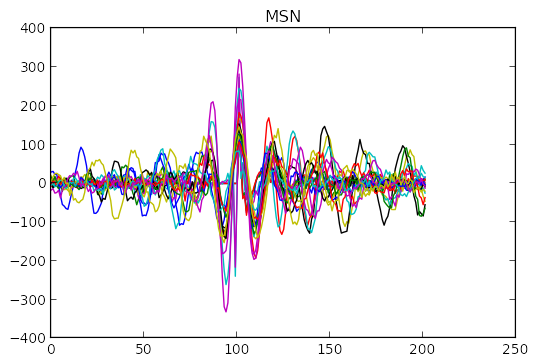

In [26]:
from row_parser import unpackArray
import numpy
def g(row):
    return unpackArray(row[field],data_type=numpy.float64)
def unpackArray(x,data_type=numpy.int16):
    return numpy.frombuffer(x,dtype=data_type)
L=df.take(20)
field='MSN'
for a in L:
    plot(g(a))
title(field);

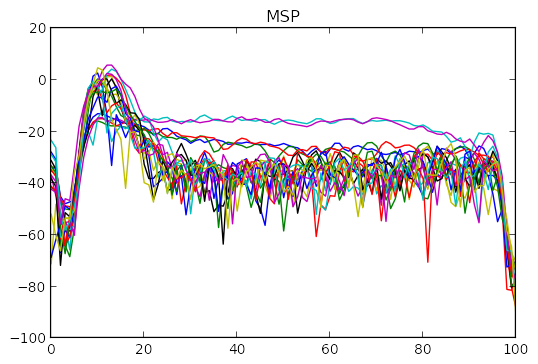

In [27]:
field='MSP'
for a in L:
    plot(g(a))
title(field);

In [28]:
from time import time
from spark_PCA import *


In [29]:
def unpack(bytearray):
    return unpackArray(bytearray,data_type=numpy.float64)
feature='MSP'
rdd=df.rdd.map(g)
print type(rdd)
rdd.first()

<class 'pyspark.rdd.PipelinedRDD'>


array([-34.2238, -33.9033, -45.031 , -47.8457, -47.1611, -46.5836,
       -31.0557, -22.687 , -17.3832, -14.3108, -12.9905, -13.0394,
       -13.8941, -14.6441, -15.2878, -16.2532, -16.6215, -16.6206,
       -16.9976, -17.4435, -18.0617, -19.3168, -21.2616, -20.681 ,
       -18.8653, -18.7143, -19.9128, -21.6954, -22.4543, -23.0892,
       -24.4656, -23.4138, -22.9504, -24.1552, -23.5533, -22.9531,
       -23.2596, -23.7252, -24.8302, -24.7406, -24.3184, -24.4116,
       -24.0277, -24.2984, -24.8872, -24.9365, -24.9002, -24.7977,
       -25.4393, -25.1422, -24.5324, -25.225 , -25.9022, -26.1996,
       -27.411 , -29.3391, -27.5361, -26.2795, -27.7208, -29.2339,
       -26.7324, -24.4358, -24.463 , -26.7423, -27.4951, -25.8256,
       -25.3701, -26.1414, -26.9244, -26.59  , -27.3737, -28.509 ,
       -28.7962, -28.4409, -28.0141, -28.8132, -28.4144, -27.5241,
       -27.715 , -28.2131, -27.2487, -26.7068, -28.5241, -28.7847,
       -26.4997, -26.9417, -28.3392, -26.6263, -25.5226, -26.7

In [30]:
t0=time()
rdd.cache().count()
print time()-t0

16.9310259819


In [31]:
t0=time()
COV=computeCov(rdd)
print time()-t0

shape of E= (101,) shape of NE= (101,)
51.7302320004


In [ ]:
M=COV['Mean']
S=np.sqrt(COV['Var'])
plot(M-S)
plot(M)
plot(M+S)

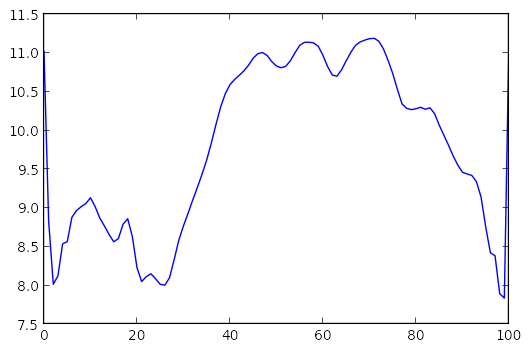

In [32]:
plot(np.sqrt(COV['Var']))

In [33]:
eigval,eigvec=LA.eig(COV['Cov'])

In [34]:
eigval=eigval/sum(eigval)
sum(eigval)

1.0

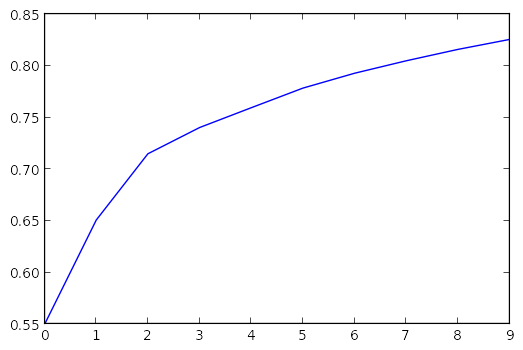

In [35]:
plot(cumsum(eigval[:10]))

In [36]:
shape(eigvec)

(101, 101)

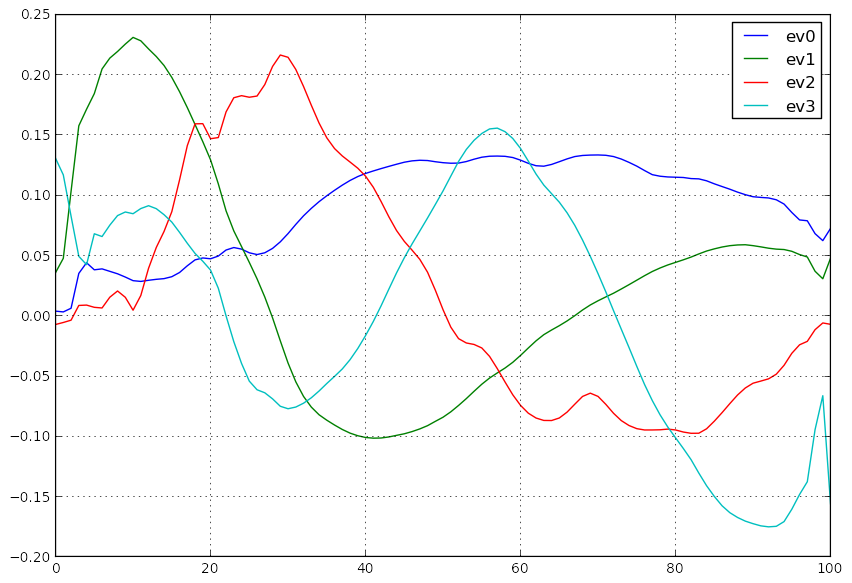

In [37]:
figure(figsize=[10,7])
for i in range(4):
    plot(eigvec[:,i],label='ev'+str(i))
legend()
grid()

In [47]:
df.columns

['time',
 'species',
 'site',
 'rec_no',
 'bout_i',
 'peak2peak',
 'MSN',
 'MSP',
 'TPWS1',
 'MD1',
 'FD1',
 'TPWS2',
 'MD2',
 'FD2',
 'TPWS3',
 'MD3',
 'FD3']

In [40]:
sdf=df.sort([df.site,df.time])

In [48]:
sdf.cache().count()

6353182

In [46]:
sdf.sele

+-----+-----+
|TPWS1|TPWS2|
+-----+-----+
|    1|    1|
|    1|    1|
|    1|    1|
|    1|    1|
|    1|    1|
+-----+-----+
only showing top 5 rows



In [57]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [137]:
import pyspark
sdf.createOrReplaceTempView("sc")

sites=spark.sql("SELECT sc.site FROM sc")
sites.distinct().show()

+----+
|site|
+----+
|  MC|
|  GC|
|  DT|
+----+



In [170]:
from pyspark.sql.functions import to_utc_timestamp, datediff, udf
import pandas as pd

ImportError: No module named pandas

In [ ]:
# Function to calculate time delta
def time_delta(y,x): 
    end = pd.to_datetime(y)
    start = pd.to_datetime(x)
    delta = (end-start)
    return delta
spark.udf.register("time_delta", time_delta)

In [166]:
query="""
SELECT sc.species,sc.TPWS1 as tpws1,sc.TPWS2 as tpws2,sc.time as current,
       (LAG(sc.time) OVER (PARTITION BY sc.species ORDER BY sc.time)) as prev, 
       time_delta(sc.time,
                (LAG(sc.time) OVER (PARTITION BY sc.species ORDER BY sc.time)))
       from sc
"""
expand =spark.sql(query)
expand.show(10)

Py4JJavaError: An error occurred while calling o1395.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 185 in stage 195.0 failed 4 times, most recent failure: Lost task 185.3 in stage 195.0 (TID 14934, 10.0.0.227): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/ec2-user/spark/python/lib/pyspark.zip/pyspark/worker.py", line 172, in main
    process()
  File "/home/ec2-user/spark/python/lib/pyspark.zip/pyspark/worker.py", line 167, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/home/ec2-user/spark/python/lib/pyspark.zip/pyspark/worker.py", line 106, in <lambda>
    func = lambda _, it: map(mapper, it)
  File "/home/ec2-user/spark/python/lib/pyspark.zip/pyspark/worker.py", line 92, in <lambda>
    mapper = lambda a: udf(*a)
  File "/home/ec2-user/spark/python/lib/pyspark.zip/pyspark/worker.py", line 70, in <lambda>
    return lambda *a: f(*a)
  File "<ipython-input-165-ec42d5d75b3b>", line 4, in time_delta
NameError: global name 'to_datetime' is not defined

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec$$anonfun$doExecute$1.apply(BatchEvalPythonExec.scala:124)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec$$anonfun$doExecute$1.apply(BatchEvalPythonExec.scala:68)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:766)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:766)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:319)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:283)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:319)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:283)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:319)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:283)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:70)
	at org.apache.spark.scheduler.Task.run(Task.scala:85)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:274)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1145)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:615)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1450)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1438)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1437)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1437)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:811)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:811)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:811)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1659)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1618)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1607)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:632)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1871)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1884)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1897)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:347)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:39)
	at org.apache.spark.sql.Dataset$$anonfun$org$apache$spark$sql$Dataset$$execute$1$1.apply(Dataset.scala:2183)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:57)
	at org.apache.spark.sql.Dataset.withNewExecutionId(Dataset.scala:2532)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$execute$1(Dataset.scala:2182)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$collect(Dataset.scala:2189)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:1925)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:1924)
	at org.apache.spark.sql.Dataset.withTypedCallback(Dataset.scala:2562)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:1924)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2139)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:239)
	at sun.reflect.GeneratedMethodAccessor42.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:606)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:237)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:128)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:211)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/ec2-user/spark/python/lib/pyspark.zip/pyspark/worker.py", line 172, in main
    process()
  File "/home/ec2-user/spark/python/lib/pyspark.zip/pyspark/worker.py", line 167, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/home/ec2-user/spark/python/lib/pyspark.zip/pyspark/worker.py", line 106, in <lambda>
    func = lambda _, it: map(mapper, it)
  File "/home/ec2-user/spark/python/lib/pyspark.zip/pyspark/worker.py", line 92, in <lambda>
    mapper = lambda a: udf(*a)
  File "/home/ec2-user/spark/python/lib/pyspark.zip/pyspark/worker.py", line 70, in <lambda>
    return lambda *a: f(*a)
  File "<ipython-input-165-ec42d5d75b3b>", line 4, in time_delta
NameError: global name 'to_datetime' is not defined

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec$$anonfun$doExecute$1.apply(BatchEvalPythonExec.scala:124)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec$$anonfun$doExecute$1.apply(BatchEvalPythonExec.scala:68)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:766)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:766)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:319)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:283)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:319)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:283)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:319)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:283)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:70)
	at org.apache.spark.scheduler.Task.run(Task.scala:85)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:274)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1145)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:615)
	... 1 more


In [140]:
#expand.createOr
pairs=expand.collect()
pairs[1]

KeyboardInterrupt: (None, <function <lambda> at 0x7f1eb8be9938>, (u'Cuviers', 1, 0, 1302677247885388, 1302677245664569))

In [113]:
diff=[]
sites=[]
i=0;
for r in pairs:
    if r.prev is None:
        print 'new site',i
        sites.append(i)
        continue
    diff.append((r.current-r.prev).total_seconds())
    i+=1
    if i%100000==0:
        print i,'\r',
diff[:10], sites

new site 0
new site 3478055


([5.16865,
  20.207203,
  0.509915,
  76.753788,
  1.104158,
  0.399304,
  6.384284,
  0.520627,
  0.695671,
  2.330806],
 [0, 3478055])

In [115]:
diff[-10:]

[0.340564,
 183.243434,
 0.360448,
 2.000794,
 0.224229,
 0.322942,
 0.288733,
 0.282346,
 0.320678,
 0.230335]

In [116]:
adiff=np.array(diff)

In [124]:
adiff.sort()
adiff=adiff[::-1]
adiff[:10]

array([ 3286569.950581,  2215608.044567,  1616404.238263,  1467938.455337,
        1243815.925264,  1102038.05046 ,   975306.587567,   948201.111787,
         854235.63025 ,   812123.235174])

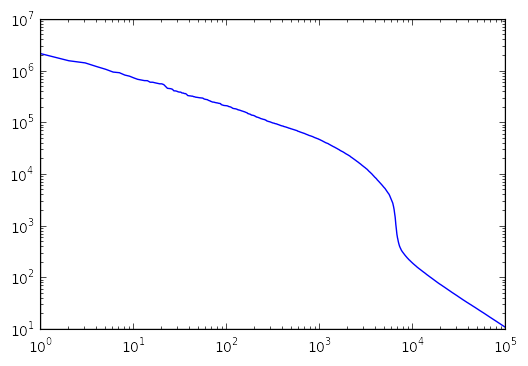

In [127]:
loglog(adiff[:100000])

In [131]:
sum(adiff>40*60)

6221

In [269]:
st=sort(times_array[1:]-times_array[:-1])

In [273]:
a=[1,2,3]
a.reverse()
a

[3, 2, 1]

In [ ]:
[1,2,3].reverse

In [275]:
st_sec=[t.total_seconds() for t in st]
st_sec.reverse()
st_sec[:10]

[12198011.460947,
 11125207.962398,
 2558266.29093,
 1649921.091146,
 603516.794639,
 526309.618293,
 298048.448728,
 181301.964808,
 165656.691039,
 162366.666418]

4963043

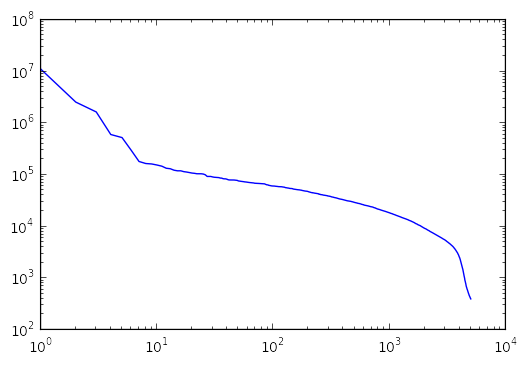

In [289]:
loglog(st_sec[:5000])
len(st_sec)

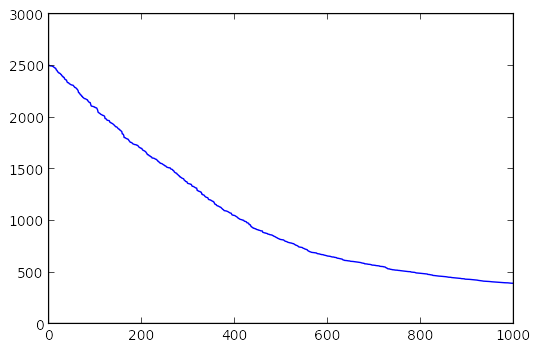

In [290]:
st_sec[4000]
plot(st_sec[4000:5000])

Group by time, then find groups that contain more than one element.

sort by time, translate time to float, collect time/index into list, find all equalities.

In [66]:
C=df.groupBy(['site','time']).count()

In [67]:
C.columns

['site', 'time', 'count']

In [77]:
doubles=C.filter("count>1")

In [78]:
doubles.count()

111649

In [101]:
X=doubles.join(df,['site','time'])
X.columns

['site',
 'time',
 'count',
 'species',
 'rec_no',
 'bout_i',
 'peak2peak',
 'MSN',
 'MSP',
 'TPWS1',
 'MD1',
 'FD1',
 'TPWS2',
 'MD2',
 'FD2',
 'TPWS3',
 'MD3',
 'FD3']

In [ ]:
pairs=X.select('site','time','bout_i','species','TPWS1','TPWS2').collect()

In [130]:
[(a.bout_i,a.species,a.TPWS1, a.TPWS2) for a in pairs]

[(37, u'Cuviers', 1, 1),
 (36, u'Gervais', 1, 0),
 (37, u'Cuviers', 1, 1),
 (36, u'Gervais', 1, 0),
 (37, u'Cuviers', 1, 1),
 (36, u'Gervais', 1, 0),
 (37, u'Cuviers', 1, 1),
 (36, u'Gervais', 1, 1),
 (37, u'Cuviers', 1, 0),
 (36, u'Gervais', 1, 1),
 (41, u'Cuviers', 1, 0),
 (40, u'Gervais', 1, 1),
 (41, u'Gervais', 1, 1),
 (43, u'Cuviers', 1, 1),
 (41, u'Gervais', 1, 1),
 (43, u'Cuviers', 1, 0),
 (41, u'Gervais', 1, 1),
 (43, u'Cuviers', 1, 0),
 (53, u'Gervais', 1, 1),
 (46, u'Cuviers', 1, 0),
 (49, u'Cuviers', 1, 1),
 (66, u'Gervais', 1, 0),
 (60, u'Cuviers', 1, 1),
 (75, u'Gervais', 1, 1),
 (63, u'Cuviers', 1, 1),
 (77, u'Gervais', 1, 1),
 (63, u'Cuviers', 1, 0),
 (77, u'Gervais', 1, 1),
 (65, u'Cuviers', 1, 0),
 (79, u'Gervais', 1, 1),
 (65, u'Cuviers', 1, 0),
 (79, u'Gervais', 1, 1),
 (65, u'Cuviers', 1, 1),
 (79, u'Gervais', 1, 0),
 (65, u'Cuviers', 1, 1),
 (79, u'Gervais', 1, 0),
 (65, u'Cuviers', 1, 1),
 (79, u'Gervais', 1, 0),
 (65, u'Cuviers', 1, 1),
 (79, u'Gervais', 1, 0),


In [131]:
pairs[:4]

[Row(site=u'DT', time=datetime.datetime(2010, 8, 31, 11, 46, 55, 681060), bout_i=37, species=u'Cuviers', TPWS1=1, TPWS2=1),
 Row(site=u'DT', time=datetime.datetime(2010, 8, 31, 11, 46, 55, 681060), bout_i=36, species=u'Gervais', TPWS1=1, TPWS2=0),
 Row(site=u'DT', time=datetime.datetime(2010, 8, 31, 11, 47, 1, 376824), bout_i=37, species=u'Cuviers', TPWS1=1, TPWS2=1),
 Row(site=u'DT', time=datetime.datetime(2010, 8, 31, 11, 47, 1, 376824), bout_i=36, species=u'Gervais', TPWS1=1, TPWS2=0)]

In [143]:
j=0
for i in range(0,len(pairs),2):
    F=pairs[i]
    S=pairs[i+1]
    if F.TPWS2 ==1 and S.TPWS2==1:
        j+=1
        if j<5:
            print j,1,F
            print j,2,S

j

1 1 Row(site=u'DT', time=datetime.datetime(2010, 8, 31, 11, 48, 33, 106371), bout_i=37, species=u'Cuviers', TPWS1=1, TPWS2=1)
1 2 Row(site=u'DT', time=datetime.datetime(2010, 8, 31, 11, 48, 33, 106371), bout_i=36, species=u'Gervais', TPWS1=1, TPWS2=1)
2 1 Row(site=u'DT', time=datetime.datetime(2010, 9, 1, 9, 30, 23, 9203), bout_i=41, species=u'Gervais', TPWS1=1, TPWS2=1)
2 2 Row(site=u'DT', time=datetime.datetime(2010, 9, 1, 9, 30, 23, 9203), bout_i=43, species=u'Cuviers', TPWS1=1, TPWS2=1)
3 1 Row(site=u'DT', time=datetime.datetime(2010, 9, 6, 23, 12, 43, 914075), bout_i=60, species=u'Cuviers', TPWS1=1, TPWS2=1)
3 2 Row(site=u'DT', time=datetime.datetime(2010, 9, 6, 23, 12, 43, 914075), bout_i=75, species=u'Gervais', TPWS1=1, TPWS2=1)
4 1 Row(site=u'DT', time=datetime.datetime(2010, 9, 7, 4, 5, 35, 184952), bout_i=63, species=u'Cuviers', TPWS1=1, TPWS2=1)
4 2 Row(site=u'DT', time=datetime.datetime(2010, 9, 7, 4, 5, 35, 184952), bout_i=77, species=u'Gervais', TPWS1=1, TPWS2=1)


10894

In [119]:
df.filter(df.TPWS3>0).show()

+----+-------+----+------+------+---------+---+---+-----+---+---+-----+---+---+-----+---+---+
|time|species|site|rec_no|bout_i|peak2peak|MSN|MSP|TPWS1|MD1|FD1|TPWS2|MD2|FD2|TPWS3|MD3|FD3|
+----+-------+----+------+------+---------+---+---+-----+---+---+-----+---+---+-----+---+---+
+----+-------+----+------+------+---------+---+---+-----+---+---+-----+---+---+-----+---+---+



In [124]:
pairs.filter(pairs.TPWS1 != 1).show()

+----+--------------------+-------+-----+-----+
|site|                time|species|TPWS1|TPWS2|
+----+--------------------+-------+-----+-----+
|  DT|2010-09-18 19:58:...|Cuviers|    0|    1|
|  DT|2011-03-13 13:09:...|Gervais|    0|    1|
|  DT|2011-03-13 13:11:...|Gervais|    0|    1|
|  DT|2011-03-13 13:11:...|Gervais|    0|    1|
|  DT|2011-03-13 13:14:...|Gervais|    0|    1|
|  DT|2011-04-04 20:02:...|Cuviers|    0|    1|
|  DT|2011-04-04 20:11:...|Cuviers|    0|    1|
|  DT|2011-04-13 12:29:...|Cuviers|    0|    1|
|  DT|2011-04-20 21:43:...|Gervais|    0|    1|
|  DT|2011-04-20 21:43:...|Gervais|    0|    1|
|  DT|2011-05-25 01:30:...|Cuviers|    0|    1|
|  DT|2011-05-25 01:31:...|Cuviers|    0|    1|
|  DT|2011-05-25 01:38:...|Cuviers|    0|    1|
|  DT|2011-05-25 01:39:...|Cuviers|    0|    1|
|  DT|2011-05-31 01:06:...|Gervais|    0|    1|
|  DT|2011-05-31 01:06:...|Gervais|    0|    1|
|  DT|2011-05-31 01:08:...|Gervais|    0|    1|
|  DT|2011-05-31 01:16:...|Gervais|    0

In [204]:
Bouts=sdf.groupby(['site','bout_i']).count().collect()
Bouts[-10:]

[Row(site=u'DT', bout_i=792, count=224),
 Row(site=u'MC', bout_i=134, count=1783),
 Row(site=u'GC', bout_i=67, count=4363),
 Row(site=u'DT', bout_i=166, count=6923),
 Row(site=u'DT', bout_i=102, count=11598),
 Row(site=u'DT', bout_i=11, count=17723),
 Row(site=u'DT', bout_i=297, count=2015),
 Row(site=u'DT', bout_i=682, count=121),
 Row(site=u'MC', bout_i=14, count=7563),
 Row(site=u'GC', bout_i=133, count=152)]

In [205]:
len(Bouts)

1282

In [231]:
bout=sdf.where("site='DT' and bout_i=11").collect()
bout.sort(key=lambda x:x.time)
len(bout)

17723

In [232]:
from collections import Counter

In [233]:
Counter([(b.species,b.TPWS1,b.TPWS2) for b in bout])

Counter({(u'Cuviers', 1, 0): 3,
         (u'Cuviers', 1, 1): 4640,
         (u'Gervais', 1, 0): 7649,
         (u'Gervais', 1, 1): 5431})

In [234]:
s=[]
c=[]
t0=bout[0].time
for i in range(len(bout)):
    s.append((bout[i].time-t0).total_seconds())
    c.append('b' if bout[i].species==u'Cuviers' else 'r')

In [235]:
len(s),len(c)

(17723, 17723)

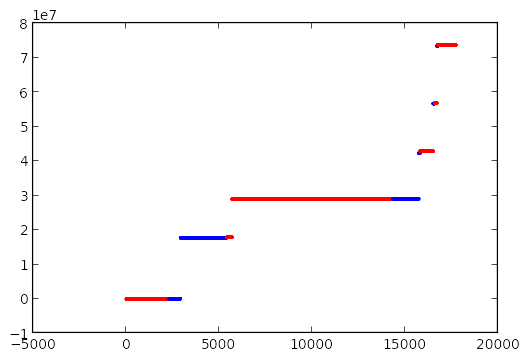

In [236]:
scatter(range(len(s)),s,marker='.',edgecolors='none',c=c);

In [242]:
dt=[]
for i in range(len(bout)-1):
    dt.append((bout[i+1].time-bout[i].time).total_seconds())
dt.sort()
dt[:10]

[0.029772,
 0.029943,
 0.029954,
 0.029994,
 0.029994,
 0.030004,
 0.030014,
 0.030014,
 0.030014,
 0.030014]

In [241]:
11084572.0/(24*3600)

128.2936574074074

In [292]:
window = Window.orderBy("date").rowsBetween(Window.unboundedPreceding, Window.currentRow)
Window?

AttributeError: type object 'Window' has no attribute 'unboundedPreceding'

In [296]:
from pyspark.sql.window import Window
w = Window.partitionBy("site").orderBy("time").rowsBetween(0,1)

In [298]:
sdf.select(sdf.time.over(w)).show()

AnalysisException: u"Expression 'time#0' not supported within a window function.;"

In [309]:
from pyspark.sql.functions import lag
from pyspark.sql.window import Window
w = Window.partitionBy("site").orderBy("time")
sdf.select('time',(lag(sdf['time']).over(w) - sdf['time']).alias('diff')).show()

AnalysisException: u"cannot resolve '(lag(`time`, 1, NULL) OVER (PARTITION BY `site` ORDER BY `time` ASC ROWS BETWEEN 1 PRECEDING AND 1 PRECEDING) - `time`)' due to data type mismatch: '(lag(`time`, 1, NULL) OVER (PARTITION BY `site` ORDER BY `time` ASC ROWS BETWEEN 1 PRECEDING AND 1 PRECEDING) - `time`)' requires (numeric or calendarinterval) type, not timestamp;"

TypeError: 'Column' object is not callable